# Baseline model for batch monitoring example

In [2]:
import requests
import datetime
import pandas as pd

# from evidently import ColumnMapping
# from evidently.report import Report
# from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# pip install evidently==0.1.60


In [3]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-02.parquet: 100%|█| 1428262/1428262 [00:09<00:00, 151229.80it/s, save to ./data/green_
green_tripdata_2022-01.parquet: 100%|█| 1254291/1254291 [00:08<00:00, 150034.25it/s, save to ./data/green_


In [4]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [ ]:
jan_data.describe()

In [6]:
jan_data.shape

(62495, 20)

In [ ]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [8]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

In [ ]:
jan_data.duration_min.hist()

In [10]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [11]:
jan_data.shape


(55211, 21)

In [12]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [13]:
model = LinearRegression()


In [14]:
model.fit(train_data[num_features + cat_features], train_data[target])


LinearRegression()

In [15]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [16]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [17]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.804665373785062
4.142064073688447


# Dump model and reference data

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [19]:
val_data.to_parquet('data/reference.parquet')

<Axes: >

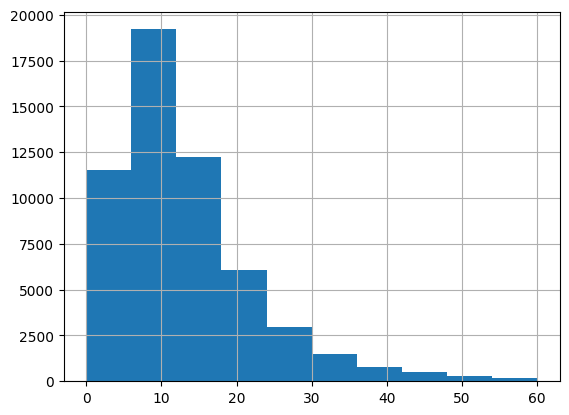